In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# Задача
## Создание датафрейма, имитирующего поведение пользователей в рамках активно развивающегося продукта

## Цель подготовить датафрейм:
- позволяющий генерировать данные, позволяющие замерять основные продуктовые метрики
- на основе которого можно создать онлайн ETL для симуляции жизни продукта
- позволяющий после ETL проводить эксперименты, проверку гипотез, АБ/АА тестирование, замер MDE

## Результатом должны стать данные, позволяющие создать пет проект, для отработки навыков аналитика.

#### Исходные данные
- задают стартовые настройки,
- могут изменяться при каждом запуске ноутбука, что изменит итоговую генерацию данных (как по объему так и по содержанию) 

In [2]:
# Задаём временные параметры
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
days = (end_date - start_date).days + 1

# Показатели прироста пользователей
initial_users = 47  # Начальное количество пользователей
target_users = 475 # Цель по приросту юзеров на конец периода
noise_std = 30 # Уровень шума (среднее квадтратичное отклонение) при генерации новых пользователей

# mean_growth = 0.015  # Средний прирост в день (доля - не процент)
# growth_std = 0.006  # Отклонение изменения прироста

# Параметры количества просмотров в день для регулярного пользователя
mean_visits_per_day = 12  # Среднее количество визитов в день
std_visits_per_day = mean_visits_per_day * 0.30  # Стандартное отклонение 30%


# Параметры количества просмотров в день для нерегулярного пользователя
lt = 15 # Средний срок жизни непостоянного пользователя
std_lt = 5 # стандартное отклонение в сроке жихни пользователя

# Среднее и стандартное отклонение для логнормального распределения визитов нерегулярных пользователей
mean_visits_per_day_log = 10  # Среднее количество визитов
std_visits_per_day_log = 3  # Стандартное отклонение

## Универсальные функции

### Генерирует время захода юзеров по следующим правилам

#### Основной поток 
(10:00 - 22:30)

Это самая большая часть потока пользователей, которая составляет 70% от общего числа пользователей (значение n * 0.7).
Время для этих пользователей генерируется с использованием логнормального распределения с параметрами mean=2.5 (среднее/матожидание) и sigma=0.5 (стандартное отклонение). Это создает большую концентрацию пользователей в районе 10:00 - 22:30, с возможными пиками в разные часы.


#### Вечерний всплеск 
(21:00 - 22:30)

На всплеск приходится +20% от общего числа пользователей (значение n * 0.2).
Время для этих пользователей генерируется с использованием нормального распределения с параметрами loc=21.75 (среднее = время 21:45) и scale=0.3 (стандартное отклонение от среднего). Это создаёт более плотный поток в поздние часы вечера, около 21:30 - 22:30.

#### Ночной поток
(23:00 - 10:00)

Это 10% от общего числа пользователей (значение n * 0.1).
Для этих пользователей генерируется время с использованием нормального распределения с параметрами loc=4.5 (время 4:30) и scale=1.0, что даёт распределение с пиками около ночи. Однако, время ограничивается в пределах 00:00 - 10:00 с помощью функции np.clip.

In [3]:
# Функция для генерации времени входа
def generate_visit_time(n, date):
    # Основной поток (10:00 - 22:30)
    morning_peak = np.random.lognormal(mean=2.5, sigma=0.5, size=int(n * 0.7))  # Основной поток
    evening_peak = np.random.normal(loc=21.75, scale=0.3, size=int(n * 0.2))  # Вечерний всплеск
    
    # Добавляем ночной поток (23:00 - 10:00), он в 2 раза слабее вечернего
    night_users = int(n * 0.1)  # 10% от общего числа пользователей
    if night_users > 0:
        night_base = np.random.normal(loc=4.5, scale=1.0, size=night_users)  # Среднее 4:30, разброс 1 час
        night_base = np.clip(night_base, 0, 10)  # Ограничиваем 00:00 - 10:00
    else:
        night_base = np.array([])  # Добавляем пустой массив, если пользователей нет

    # Объединяем все периоды
    hours = np.concatenate([morning_peak, evening_peak, night_base])
    hours = np.clip(hours, 0, 22.5)  # Общий диапазон 00:00 - 22:30
    minutes = np.random.randint(0, 60, len(hours))

    return [date + timedelta(hours=float(h), minutes=int(m)) for h, m in zip(hours, minutes)]

### На основе датафрейма с ежедневным количеством посещений для каждого юзера создает строки (объекты) с посещениями

In [4]:
def create_visit_lines(data, target_date):
    target_date = datetime.strptime(target_date , '%Y-%m-%d').date()
    
    data_filtered = data[data['datetime'].dt.date == target_date].copy()
    data_filtered = data_filtered[['datetime', 'user_id', 'first_visit_unique', 'visits_per_day']]
    
    # Для каждого пользователя генерируем визиты
    user_visit_data = []
    
    for _, row in data_filtered.iterrows():
        user_id = row['user_id']
        visits_count = row['visits_per_day']
        first_visit_unique = row['first_visit_unique']
    
        visit_times = generate_visit_time(visits_count, datetime(target_date.year, target_date.month, target_date.day))    
        
        for visit_time in visit_times:
            user_visit_data.append({
                'datetime': visit_time,
                'user_id': user_id,
                'action': 'view',
                'type': 'main', 
            })
    
    # Преобразуем список в DataFrame
    df_visit_times = pd.DataFrame(user_visit_data)
    df_visit_times['datetime'] = pd.to_datetime(df_visit_times['datetime'])
    
    # Добавляем first_visit_unique к каждому user_id
    df_visit_times = df_visit_times.merge(
        data_filtered[['user_id', 'first_visit_unique']], on='user_id', how='left'
    )

    # Фильтруем по first_visit_unique
    df_visit_times = df_visit_times[df_visit_times['datetime'] >= df_visit_times['first_visit_unique']]

    # Удаляем first_visit_unique из финального датасета
    df_visit_times = df_visit_times.drop(columns=['first_visit_unique'])

    return df_visit_times

### Базовый график для отражения динамики измнения количественных данных
(например посещений в день, колебания внутри дня и т.п.)

In [5]:
def line_plot(dataset, figsize = (12, 3),
              label='Количество пользователей', xlabel='Дни',
              ylabel = 'Количество пользователей'):
    plt.figure(figsize=figsize)
    plt.plot(dataset, label=label, color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.legend()
    plt.grid(True)
    plt.show()

## Этап 1. Генерируем новых пользователей для каждого дня жизни продукта

## Этап 1.1. Выбираем способ формирования пула новых пользователей

### 1.1.1. Ежедневный прирост на 1,5%
для реалистичности добавляем колебания количества новых пользователей
(нормальное распредление со стандартным отклонением 0.6%)

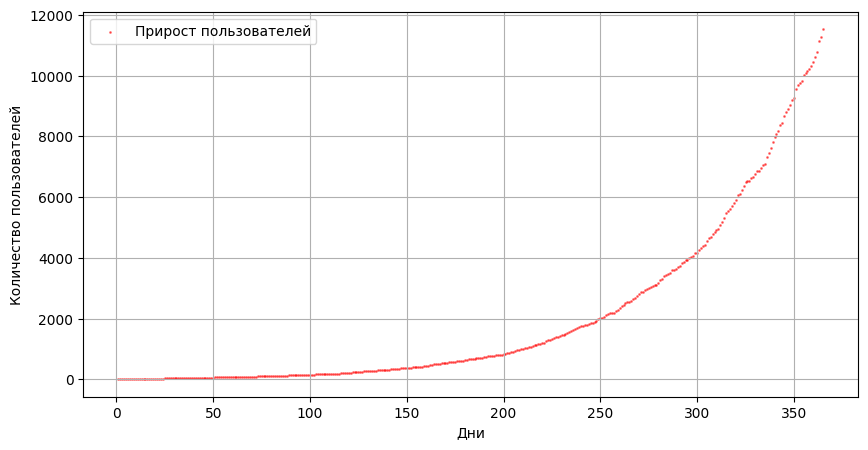

In [6]:
# Задаём временные параметры
test_start_date = datetime(2025, 1, 1)
test_end_date = datetime(2025, 12, 31)
test_days = (test_end_date - test_start_date).days + 1

# Показатели прироста пользователей
test_initial_users = 5   # Начальное количество пользователей
test_mean_growth = 0.015 # Средний прирост в день (доля - не процент)
test_growth_std = 0.009  # Отклонение изменения прироста

# Генерируем количество пользователей на каждый день
daily_users = [test_initial_users]

for _ in range(1, test_days):
    prev_users = daily_users[-1]
    adjusted_growth = test_mean_growth + np.random.normal(0, test_growth_std)  # Случайное изменение прироста
    new_users = int(np.ceil(prev_users * (1 + adjusted_growth)))  # Применяем изменённый прирост и округляем вверх
    daily_users.append(max(new_users, prev_users + 1))  # Гарантируем рост хотя бы на 1 пользователя

# Визуализация
x = np.arange(1, test_days + 1)
y = np.array(daily_users)

plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='red', s=1, alpha=0.5, label='Прирост пользователей')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()
plt.show()

In [7]:
y.sum()

750588

### Промежуточный вывод:
- имееем чрезмерно большое количество данных для тренировочного датасета (у каждого юзера быдут дополнительно формироваться визиты и целевые действия, что увеличит общее количество записей в сотни раз)
- кривая прироста пользователейц выглядит неестественно в той части, где имеем экспоненциальный рост (что понятно для полиномиальной функции, несмотря на небольшую степень)
- у классического it  продукта даже при резком старте со временем прирост новых пользователей замедляется в виду насыщения рынка 

### 1.1.2. Генерируем логарифмический рост пользователей с фиксацией конечного их количества
Логарифмический рост дает картину близкую к реальной, а именно:
- имеем буст прироста в начале периода
- далее прирост замедляется
- далее выход на плато
  
Для реалистичности добавляем колебания количества новых пользователей
(нормальное распредление со стандартным отклонением 0.6%)

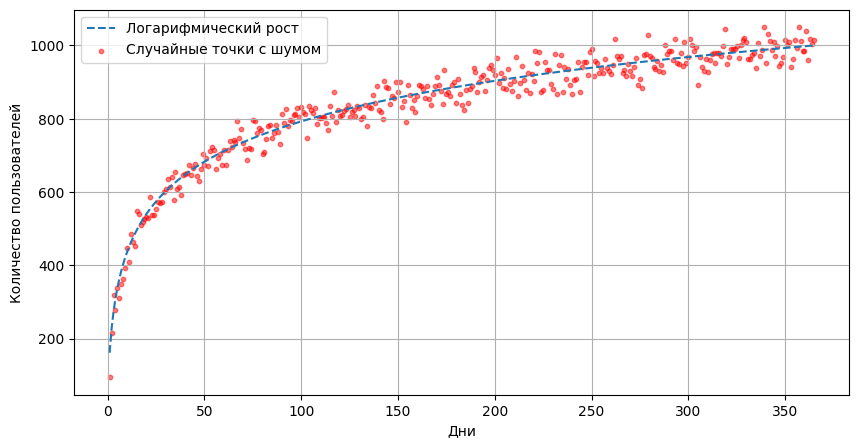

In [8]:
# Задаём временные параметры
test_start_date = datetime(2025, 1, 1)
test_end_date = datetime(2025, 12, 31)
test_days = (test_end_date - test_start_date).days + 1

# Показатели прироста пользователей
test_initial_users = 50     # Начальное количество пользователей
test_target_users = 1000   # Количество пользователей на конец периода
test_noise_std = 30

# Генерируем дни от 1 до test_days
x = np.arange(1, test_days + 1)

# Логарифмический рост пользователей
growth_factor = np.log1p(x)  # log1p(x) = log(1 + x), избегает log(0)
y = test_initial_users + (test_target_users - test_initial_users) * (growth_factor / max(growth_factor))

# Добавляем шум
noise = np.random.normal(scale=noise_std, size=len(y))  # Увеличим разброс
y_noisy = y + noise
y_noisy = np.maximum(y_noisy, test_initial_users)  # Убираем отрицательные значения

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Логарифмический рост', linestyle='dashed')
plt.scatter(x, y_noisy, color='red', s=10, alpha=0.5, label='Случайные точки с шумом')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()
plt.show()

In [9]:
y_noisy.sum()

307015.5632605435

In [10]:
y.sum()

307667.02326298255

## Вывод по итогам этапа
- останавливаемся на логарифмическом росте, так как он более реалистично отражает прирост пользователей
- в связи с быстрым ростом количества пользователей (чатсь из которых станет постоянными), количество визитов/просмотров у нас будет приближаться (а возможно и превысит) аналогичные показатели для данных сгенерированных по формуле с фиксированным ежедненым приростом.  

## Этап 1.2. Сгенерируем данные, симулирующие ежедневный приход новых пользователей


In [11]:
# Генерируем количество пользователей на каждый день 
daily_users = [initial_users]

# Генерируем дни от 1 до days
x = np.arange(1, days + 1)

# Логарифмический рост пользователей
growth_factor = np.log1p(x)  # log1p(x) = log(1 + x), избегает log(0)
y = initial_users + (target_users - initial_users) * (growth_factor / max(growth_factor))

# Добавляем шум
noise = np.random.normal(scale=noise_std, size=len(y))  # Увеличенный разброс
daily_users = np.maximum(y + noise, initial_users).astype(int)  # Убираем отрицательные значения и округляем

daily_users[-10:]

array([474, 476, 514, 455, 456, 462, 441, 428, 469, 516])

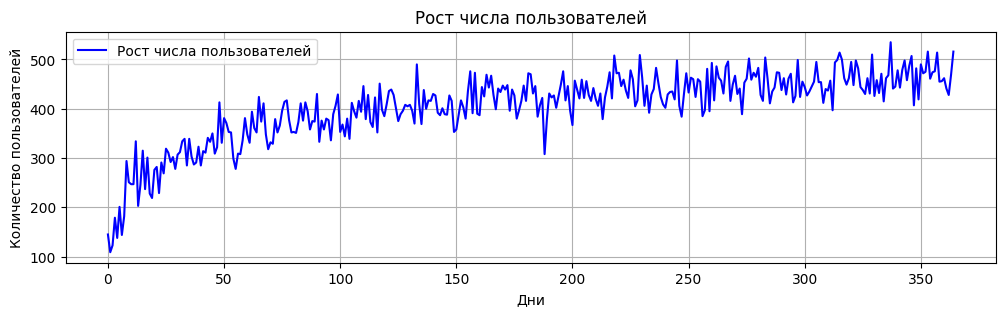

In [12]:
line_plot(daily_users, label='Рост числа пользователей')

#### Создаем датафрейм где отразим приход новых пользователей
с указанием для каждого первого времени пользования продуктом

In [13]:
%%time
# Создаём датафрейм
data = []

user_counter = 1  # Инициализация счётчика для user_id

for i, user_count in enumerate(daily_users):
    date = start_date + timedelta(days=i)
    visit_times = generate_visit_time(user_count, date)

    for visit_time in visit_times:
        data.append([visit_time, user_counter, 'view', 'main', visit_time]) 
        user_counter += 1  # Увеличиваем счётчик для следующего пользователя

# Создаём DataFrame
df = pd.DataFrame(data, columns=["datetime", "user_id", "action", "type", "first_visit"])

# Проверка результата
df.head()

CPU times: user 721 ms, sys: 10.8 ms, total: 732 ms
Wall time: 298 ms


,datetime,user_id,action,type,first_visit
0,2025-01-01 11:45:06.374215,1,view,main,2025-01-01 11:45:06.374215
1,2025-01-01 17:26:18.032554,2,view,main,2025-01-01 17:26:18.032554
2,2025-01-01 07:22:06.472953,3,view,main,2025-01-01 07:22:06.472953
3,2025-01-01 15:43:10.209010,4,view,main,2025-01-01 15:43:10.209010
4,2025-01-01 09:36:50.599212,5,view,main,2025-01-01 09:36:50.599212


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146990 entries, 0 to 146989
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     146990 non-null  datetime64[ns]
 1   user_id      146990 non-null  int64         
 2   action       146990 non-null  object        
 3   type         146990 non-null  object        
 4   first_visit  146990 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 5.6+ MB


#### Посмотрим визуально внутридневные колебания

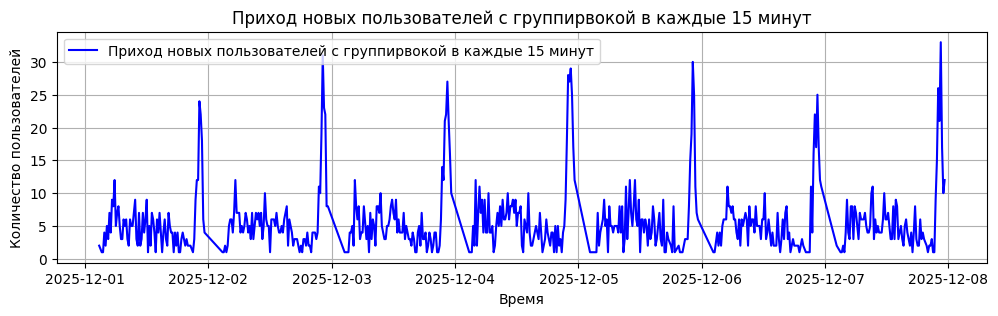

In [15]:
# 1. Фильтруем данные за 7 дней
df_february = df[(df['datetime'] >= '2025-12-01') & (df['datetime'] < '2025-12-8')]

# 2. Округляем время до 15-минутных интервалов
df_february['time_15min'] = df_february['datetime'].dt.floor('15T')

# 3. Группируем по 15-минутным интервалам
df_february = df_february.groupby('time_15min').size()

line_plot(df_february, label='Приход новых пользователей с группирвокой в каждые 15 минут', xlabel='Время')


## Этап 2. Разделяем пользователей на постоянных и случайных

In [16]:
# Генерируем вероятность с нормальным распределением
mean_prob = 0.25  # Средняя вероятность 25%
std_dev = 0.10  # Стандартное отклонение 10%

# Создаем столбец permanent_user
df['permanent_user'] = np.random.normal(mean_prob, std_dev, size=len(df)) > np.random.rand(len(df))

In [17]:
df[df.permanent_user == True].shape[0] / df[df.permanent_user == False].shape[0]

0.3352894686639838

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146990 entries, 0 to 146989
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        146990 non-null  datetime64[ns]
 1   user_id         146990 non-null  int64         
 2   action          146990 non-null  object        
 3   type            146990 non-null  object        
 4   first_visit     146990 non-null  datetime64[ns]
 5   permanent_user  146990 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 5.7+ MB


In [19]:
df.head()

,datetime,user_id,action,type,first_visit,permanent_user
0,2025-01-01 11:45:06.374215,1,view,main,2025-01-01 11:45:06.374215,False
1,2025-01-01 17:26:18.032554,2,view,main,2025-01-01 17:26:18.032554,False
2,2025-01-01 07:22:06.472953,3,view,main,2025-01-01 07:22:06.472953,True
3,2025-01-01 15:43:10.209010,4,view,main,2025-01-01 15:43:10.209010,False
4,2025-01-01 09:36:50.599212,5,view,main,2025-01-01 09:36:50.599212,False


## Этап 3. Рассчитаем для каждого дня количество визитов для постоянных пользователей

In [20]:
%%time

permanent_users = df[df['permanent_user'] == True]  # Фильтруем постоянных пользователей

# Даты для всех визитов (все уникальные даты из df)
dates = pd.to_datetime(df['datetime'].dt.date.unique())

# Получаем список всех user_id для постоянных пользователей
user_ids = permanent_users['user_id'].values

# Создаём массив всех дат и пользователей (по одной строке на каждый день для каждого постоянного пользователя)
dates_repeated = np.tile(dates, len(user_ids))
user_ids_repeated = np.repeat(user_ids, len(dates))


# Векторизуем создание временных меток
# Переводим даты в datetime, добавляем microseconds=1
visit_times = pd.to_datetime(dates_repeated) + timedelta(microseconds=1)

# Создаём DataFrame для добавления визитов
df_permanent_visits = pd.DataFrame({
    'datetime': visit_times,
    'user_id': user_ids_repeated,
    'action': 'view',
    'type': 'main',
    'first_visit': -1,
    'permanent_user': True
})



# Проверка результата
df_permanent_visits = pd.concat([df_permanent_visits, permanent_users])

df_permanent_visits.head()

CPU times: user 1.07 s, sys: 288 ms, total: 1.36 s
Wall time: 1.12 s


,datetime,user_id,action,type,first_visit,permanent_user
0,2025-01-01 00:00:00.000001,3,view,main,-1,True
1,2025-01-02 00:00:00.000001,3,view,main,-1,True
2,2025-01-03 00:00:00.000001,3,view,main,-1,True
3,2025-01-04 00:00:00.000001,3,view,main,-1,True
4,2025-01-05 00:00:00.000001,3,view,main,-1,True


In [21]:
%%time
# Находим минимальную дату для каждого пользователя (дата начала пользования продуктом)
first_visit_dates = permanent_users.groupby('user_id')['datetime'].min().reset_index()
first_visit_dates

# Переименовываем столбцы для последующего слияния
first_visit_dates.columns = ['user_id', 'first_visit_unique']

# Выполняем merge с оригинальным DataFrame
data = df_permanent_visits.merge(first_visit_dates, on='user_id', how='left')
data.head()

CPU times: user 858 ms, sys: 259 ms, total: 1.12 s
Wall time: 1.15 s


,datetime,user_id,action,type,first_visit,permanent_user,first_visit_unique
0,2025-01-01 00:00:00.000001,3,view,main,-1,True,2025-01-01 07:22:06.472953
1,2025-01-02 00:00:00.000001,3,view,main,-1,True,2025-01-01 07:22:06.472953
2,2025-01-03 00:00:00.000001,3,view,main,-1,True,2025-01-01 07:22:06.472953
3,2025-01-04 00:00:00.000001,3,view,main,-1,True,2025-01-01 07:22:06.472953
4,2025-01-05 00:00:00.000001,3,view,main,-1,True,2025-01-01 07:22:06.472953


In [22]:
# Оставляем только строки, где datetime >= first_visit
data = data[data['datetime'] >= data['first_visit_unique']]
data = data.sort_values(by=['datetime', 'user_id'])

data = data.reset_index()
data = data.drop(['first_visit', 'index'	], axis=1)
# Проверка результата
data.head()

,datetime,user_id,action,type,permanent_user,first_visit_unique
0,2025-01-01 03:14:44.586409,142,view,main,True,2025-01-01 03:14:44.586409
1,2025-01-01 03:54:54.267680,138,view,main,True,2025-01-01 03:54:54.267680
2,2025-01-01 04:38:43.784143,143,view,main,True,2025-01-01 04:38:43.784143
3,2025-01-01 04:57:28.542662,134,view,main,True,2025-01-01 04:57:28.542662
4,2025-01-01 05:14:52.475271,132,view,main,True,2025-01-01 05:14:52.475271


#### На данном этапе имеем датафрейм 
где для каждого постоянного пользователя начиная с первого дня его посещения есть запись,

куда далее мы добавим количество просмотров в этот день


Характеристики распредления заданы в начале ноутбука и одинаковы для каждого постоянного пользователя

In [23]:
# Генерируем серию случайных чисел для каждой строки в DataFrame
# Характеристики распредления заданы в начале ноутбука и одинаковы для каждого постоянного пользователя

visits_per_day_series = np.random.normal(mean_visits_per_day, std_visits_per_day, size=len(data))
# Округляем значения, чтобы количество визитов было целым числом
visits_per_day_series = visits_per_day_series.round().astype(int)

# Добавляем эту серию в исходный DataFrame
data['visits_per_day'] = visits_per_day_series

data = data[data['visits_per_day'] > 0]

# Проверка результата
data.head()

,datetime,user_id,action,type,permanent_user,first_visit_unique,visits_per_day
0,2025-01-01 03:14:44.586409,142,view,main,True,2025-01-01 03:14:44.586409,13
1,2025-01-01 03:54:54.267680,138,view,main,True,2025-01-01 03:54:54.267680,13
2,2025-01-01 04:38:43.784143,143,view,main,True,2025-01-01 04:38:43.784143,14
3,2025-01-01 04:57:28.542662,134,view,main,True,2025-01-01 04:57:28.542662,13
4,2025-01-01 05:14:52.475271,132,view,main,True,2025-01-01 05:14:52.475271,12


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6217337 entries, 0 to 6221747
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   datetime            datetime64[ns]
 1   user_id             int64         
 2   action              object        
 3   type                object        
 4   permanent_user      bool          
 5   first_visit_unique  datetime64[ns]
 6   visits_per_day      int64         
dtypes: bool(1), datetime64[ns](2), int64(2), object(2)
memory usage: 338.0+ MB


In [25]:
data['visits_per_day'].sum()

74677133

#### На данном этапе имеем ~ 6 млн записей group user-day

##### Общее количество строк при генерации визитов для постоянных пользователей будет ~ 74 млн
##### В связи с чем принимаем решение генерить визиты на стадии подгрузки в БД в рамках ETL

### Преподготовим данные для загрузки в БД 
- удаляем столбцы, которые мы не можем знать при реальном функционировании продукта (permanent_user)
- не смотря на то, что first_visit_unique можно всегда получить из БД простым запросом, мы оставляем данный столбец, так как он нужен нам в дальнейшем для генерации построчных посещений
- добавляем новый столбец group, значение которого будем менять при АБ тестировании (1 группа будет всегда контрольной)

In [26]:
data['group'] = 1
data = data.drop('permanent_user', axis=1)
# data = data.drop('first_visit_unique', axis=1)
data.head()

,datetime,user_id,action,type,first_visit_unique,visits_per_day,group
0,2025-01-01 03:14:44.586409,142,view,main,2025-01-01 03:14:44.586409,13,1
1,2025-01-01 03:54:54.267680,138,view,main,2025-01-01 03:54:54.267680,13,1
2,2025-01-01 04:38:43.784143,143,view,main,2025-01-01 04:38:43.784143,14,1
3,2025-01-01 04:57:28.542662,134,view,main,2025-01-01 04:57:28.542662,13,1
4,2025-01-01 05:14:52.475271,132,view,main,2025-01-01 05:14:52.475271,12,1


In [27]:
# сохраним данные в виде csv файла
data.to_csv('permanent_users.csv', index=False)

### В качестве проверки возможности дальнейшего использования 
создадим на end_date записи по каждому посещению для всех пользователей,активных в данную дату

In [28]:
%%time

target_date  = '2025-12-31'  # формат даты, который мы сможем впоследствии получить в даге airflow через контекст
res = create_visit_lines(data, target_date)
display(res.head())
display(res.info())

,datetime,user_id,action,type
0,2025-12-31 10:04:45.164109,3,view,main
1,2025-12-31 14:17:15.960898,3,view,main
2,2025-12-31 07:21:40.045976,3,view,main
3,2025-12-31 19:24:29.994721,3,view,main
4,2025-12-31 06:27:55.784429,3,view,main


<class 'pandas.core.frame.DataFrame'>
Index: 395595 entries, 0 to 396160
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  395595 non-null  datetime64[ns]
 1   user_id   395595 non-null  int64         
 2   action    395595 non-null  object        
 3   type      395595 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.1+ MB


None

CPU times: user 2.51 s, sys: 79.9 ms, total: 2.59 s
Wall time: 2.61 s


In [29]:
res[res['datetime'].dt.time == time(0, 0, 0, 1)] # проверим что функция отработала верно и не осталось данных со значениями 00:00:00.000001

,datetime,user_id,action,type


#### Функция генерации построковых посещений работает и работает за разумное время

#### Посмотрим на получившиеся данные визуально

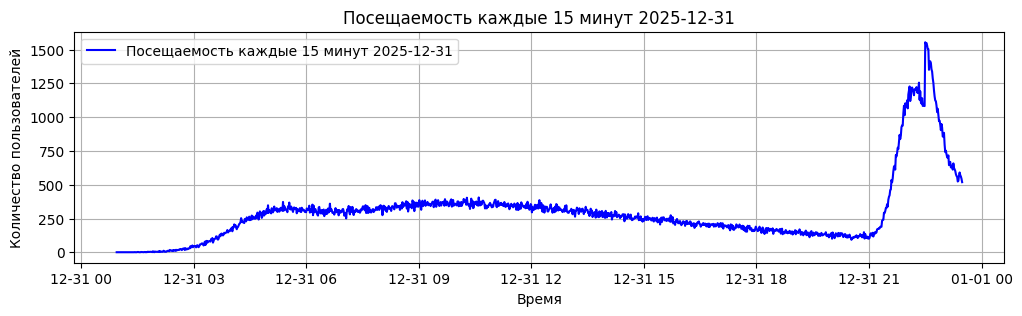

In [30]:
# Округляем время до 1-минутных интервалов
res['time_one_min'] = res['datetime'].dt.floor('1T')

# Группируем по 15-минутным интервалам
visits_one_min = res.groupby('time_one_min').size()

line_plot(visits_one_min, label='Посещаемость каждые 15 минут '+ target_date, xlabel='Время')

## Этап 4. Рассчитаем для каждого дня количество визитов для непостоянных пользователей

#### Расчет здесь более сложный, так как у каждого пользователя своя длительность жизни в рамках продукта, 
в связи с чем невозмонжо полностью векторизовать расчет количества дневных посещений в связи с чем генерация данных будет существенно более длительной

In [31]:
%%time

# Фильтруем непостоянных пользователей
non_permanent_users = df[df['permanent_user'] != True]


#Определяем `first_visit_unique` для каждого пользователя
first_visit_dates = non_permanent_users.groupby('user_id')["datetime"].min().reset_index()
first_visit_dates.columns = ['user_id', 'first_visit_unique']


exit_days = np.random.normal(loc=lt, scale=std_lt, size=len(first_visit_dates)) 

# Применяем для каждого пользователя: `exit_day = first_visit_unique + случайное число дней`
first_visit_dates['exit_day'] = first_visit_dates['first_visit_unique'] + pd.to_timedelta(exit_days.astype(int), unit='D')
first_visit_dates.head()

CPU times: user 45.1 ms, sys: 3.78 ms, total: 48.9 ms
Wall time: 16.1 ms


,user_id,first_visit_unique,exit_day
0,1,2025-01-01 11:45:06.374215,2025-01-08 11:45:06.374215
1,2,2025-01-01 17:26:18.032554,2025-01-19 17:26:18.032554
2,4,2025-01-01 15:43:10.209010,2025-01-12 15:43:10.209010
3,5,2025-01-01 09:36:50.599212,2025-01-11 09:36:50.599212
4,8,2025-01-01 11:01:36.681881,2025-01-04 11:01:36.681881


In [32]:
%%time

# Создадим список для хранения датафреймов по каждому пользователю
dfs = []

for _, row in tqdm(first_visit_dates.iterrows(), total=first_visit_dates.shape[0], desc='Generating visit qty'):
    user_id = row['user_id']
    first_visit = row['first_visit_unique']
    exit_day = row['exit_day']
    
    # Генерация всех дат от first_visit до exit_day
    dates = pd.date_range(start=first_visit, end=exit_day, freq='D')

    # # Генерация количества визитов для каждой даты по логнормальному распределению
    # visits_per_day = np.random.lognormal(mean=np.log(mean_visits_per_day_log), sigma=std_visits_per_day_log, size=len(dates)).astype(int)


    # Генерация количества визитов для каждой даты по логнормальному распределению
    visits_per_day = np.random.lognormal(mean=np.log(mean_visits_per_day_log), sigma=std_visits_per_day_log, size=len(dates)).astype(int)
    
    # Ограничиваем диапазон значений
    #visits_per_day = np.clip(round(visits_per_day), 1, mean_visits_per_day * 1.3)  # Ограничение сверху
    visits_per_day = np.clip(np.round(visits_per_day), 1, np.round(mean_visits_per_day * 1.3))

    
    # Создаем мини-датафрейм для текущего пользователя
    user_df = pd.DataFrame({
        'datetime': [datetime.combine(date, datetime.min.time()) + timedelta(microseconds=1) for date in dates],
        'user_id': user_id,
        'action': 'view',
        'type': 'main',
        'first_visit_unique': first_visit,
        # 'permanent_user': False,
        'visits_per_day': visits_per_day
    })

    # Добавляем мини-датафрейм в список
    dfs.append(user_df)

# Объединяем все мини-датафреймы в один
df_visit_times = pd.concat(dfs, ignore_index=True)

# Проверяем результат
df_visit_times.head()

Generating visit qty: 100%|█████████████████████████████████████████████| 110081/110081 [00:32<00:00, 3430.42it/s]


CPU times: user 37.5 s, sys: 1.32 s, total: 38.8 s
Wall time: 38.3 s


,datetime,user_id,action,type,first_visit_unique,visits_per_day
0,2025-01-01 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,1.0
1,2025-01-02 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,16.0
2,2025-01-03 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,1.0
3,2025-01-04 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,5.0
4,2025-01-05 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,3.0


In [33]:
df_visit_times['visits_per_day'].sum()

15324182.0

### По аналогии с постоянными пользователям преподготовим данные для загрузки в БД 
- не смотря на то, что first_visit_unique можно всегда получить из БД простым запросом, мы оставляем данный столбец, так как он нужен нам в дальнейшем для генерации построчных посещений
- добавляем новый столбец group, значение которого будем менять при АБ тестировании (1 группа будет всегда контрольной)
- проведем тестовую генерацию вихзитов для end_date и посмотри на них визуально
- сохраним в csv для дальнейшего использования

In [34]:
df_visit_times['group'] = 1


df_visit_times.head()



,datetime,user_id,action,type,first_visit_unique,visits_per_day,group
0,2025-01-01 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,1.0,1
1,2025-01-02 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,16.0,1
2,2025-01-03 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,1.0,1
3,2025-01-04 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,5.0,1
4,2025-01-05 00:00:00.000001,1,view,main,2025-01-01 11:45:06.374215,3.0,1


In [35]:
df_visit_times.to_csv('nonpermanent_users.csv', index=False)


In [36]:
%%time

target_date  = '2025-12-31'  # формат даты, который мы сможем впоследствии получить в даге airflow через контекст
res_two = create_visit_lines(df_visit_times, target_date)
display(res_two.head())
display(res_two.info())

,datetime,user_id,action,type
0,2025-12-31 12:58:03.457069,134257,view,main
1,2025-12-31 09:12:07.919166,134257,view,main
2,2025-12-31 14:05:22.112346,134257,view,main
3,2025-12-31 08:44:35.968545,134257,view,main
4,2025-12-31 07:19:32.152690,134257,view,main


<class 'pandas.core.frame.DataFrame'>
Index: 41439 entries, 0 to 42968
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  41439 non-null  datetime64[ns]
 1   user_id   41439 non-null  int64         
 2   action    41439 non-null  object        
 3   type      41439 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.6+ MB


None

CPU times: user 440 ms, sys: 4.67 ms, total: 445 ms
Wall time: 446 ms


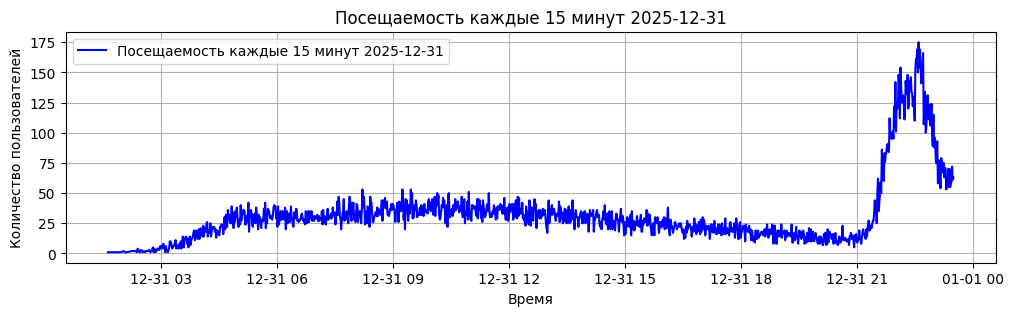

In [37]:
# Округляем время до 1-минутных интервалов
res_two['time_one_min'] = res_two['datetime'].dt.floor('1T')

# Группируем по 15-минутным интервалам
visits_one_min = res_two.groupby('time_one_min').size()

line_plot(visits_one_min, label='Посещаемость каждые 15 минут '+ target_date, xlabel='Время')

# Вывод:
- завершили первый этап подготовки данных
- можно начать формирование ETL
- на этапе ETL необзходимо будет формировать внутридненые посещения и целевые действия
- на основании сформироанных данных уже будет возможен расчет ключевых продуктовых метрик (предварительно в суперсете)


## На втором этапе подготовки данных запланировано:
- устранить ошибки первого этапа (если будут выявлены после/ в процессе разработке ETL и при расчете метрик)
- добавить рекламные компании и отдельные характеристики (для АБ тестирования и замера метрик по ним)
- добавить парсеров с аномально большим количеством посещений (3-5 раз в месяц - для настройки алертов при их выявлении)
- добавить падения сервиса  полностью (для настройки алертов и/или детекта их в процессе анализа данных)
- добавить падение сервиса для новых юзеров (также для настройки алертов или детекта их в процессе исследования данных)